In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = {}
with open('../../combind_data/bpp_outputs/fps.csv') as fp:
    fp.readline()
    for line in fp:
        try:
            (protein, struct, ligand, rank, gscore, emodel,
             rmsd, finger) = line.strip().split('\t')
            if protein not in data: data[protein] = {}
            if ligand not in data[protein]: data[protein][ligand] = {}
            finger = {(int(interaction), residue): float(score)
                      for interaction, residue, score in \
                      map(lambda x: x.split(','), finger.split(';'))}
            gscore, emodel, rmsd = float(gscore), float(emodel), float(rmsd)
            rank = int(rank)
            data[protein][ligand][rank] = (gscore, emodel, rmsd, finger)
        except:
            pass
for protein, ligand in data.items():
    print protein, len(ligand)

P00489 20
5HT2B 2
PLK1 12
Q16539 19
MGLUR5 5
ERA 19
M3 2
P07900 20
GLUT1 3
P18031 20
P56817 20
O60885 17
MEK1 20
JAK2 20
P00742 20
DTRANSP 9
SIGMA1 2
P00734 20
P00760 20
B2AR 8
GCR 18
P24941 13
B1AR 12
VITD 20
A2AR 18
SMO 7
P03951 14
P00749 20
Q9Y233 20
CHK1 20
TRPV1 2
CDK2 20
AR 11
BRAF 19
MR 13
STRANSP 5


In [3]:
features = {
    'hbond_donor':[2],
    'hbond_acceptor':[3],
    #'sb1':[0],
    'sb2':[1],
    #'sb3':[4],
    'pipi':[6],
    'picat':[7,8],
    'contact':[11]
}

max_poses = 50

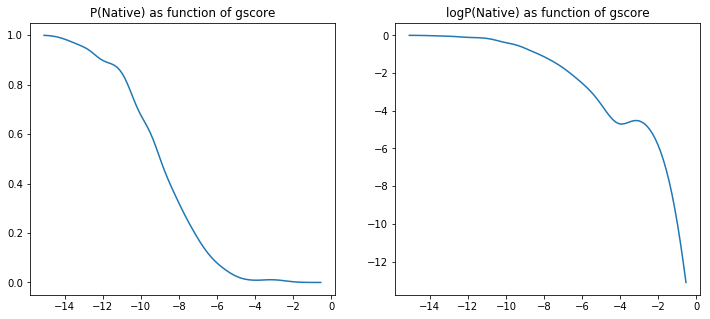

In [4]:
def gauss(mean, sd, x):
    mean, sd = float(mean), float(sd)
    return np.exp(-((x - mean)/sd)**2)

def kernel_ratio(scores, labels, sd, bins = 100):
    x = np.linspace(scores.min(), scores.max(), bins)
    ratio = []
    for _x in x:
        weights = np.array([gauss(_x, sd, score) for score in scores])
        ratio += [(labels*weights).sum() / weights.sum()]
    return x, np.array(ratio)

def interpolate(val, x, y):
    """
    Linearly interpolate f(x) = y for value val.
    """
    idx = 0
    while val > x[idx]:
        idx += 1
    if idx == x.shape[0] - 1:
        return y[-1]
    else:
        d = x[idx+1] - x[idx]
        return (  y[idx]   * (x[idx+1] - val)/d
                + y[idx+1] * (val - x[idx])/d)
    

gscores = np.array([pose[0]
                    for protein, ligands in data.items()
                    for ligand, poses in ligands.items()
                    for rank, pose in poses.items()
                    if rank < max_poses])
natives = np.array([pose[2] <= 2
                    for protein, ligands in data.items()
                    for ligand, poses in ligands.items()
                    for rank, pose in poses.items()
                    if rank < max_poses])

# Standard dev. to be used below.
sd = 0.7
f, ax = plt.subplots(1, 2, figsize = (12, 5))
p_x, p_y = kernel_ratio(gscores, natives, sd)
ax[0].set_title('P(Native) as function of gscore')
ax[0].plot(p_x, p_y)
    
ax[1].set_title('logP(Native) as function of gscore')
ax[1].plot(p_x, np.log(p_y))
plt.show()

# Normalization factors

In [5]:
def overlap(pose1, pose2, codes):
    return sum(np.sqrt(score1*pose2[-1][(c, r)])
               for (c, r), score1 in pose1[-1].items()
               if c in codes and (c, r) in pose2[-1])

def get_norm(poses1, poses2, codes):
    norm = 0
    for rank1, pose1 in poses1.items():
        if rank1 >= max_poses: continue
        for rank2, pose2 in poses2.items():
            if rank2 >= max_poses: continue
            norm = max(norm, overlap(pose1, pose2, codes))
    return norm

def gauss(mean, sd, x):
    mean, sd = float(mean), float(sd)
    return np.exp(-((x - mean)/sd)**2)

def kernel_ratio(scores, labels, sd, bins = 100):
    x = np.linspace(scores.min(), scores.max(), bins)
    ratio = []
    for _x in x:
        weights = np.array([gauss(_x, sd, score) for score in scores])
        ratio += [(labels*weights).sum() / weights.sum()]
    return x, np.array(ratio)

1282


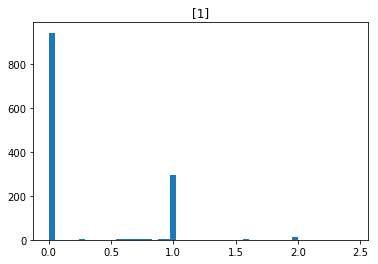

1282


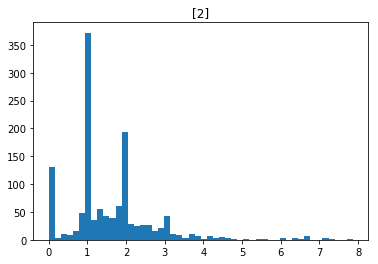

1282


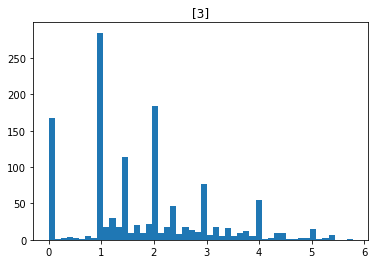

1282


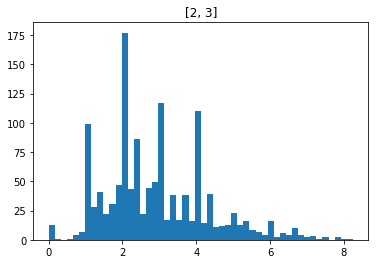

1282


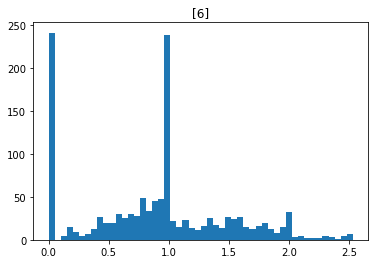

1282


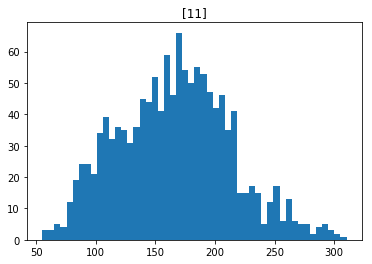

In [6]:
for codes in [[1], [2], [3], [2, 3], [6], [11]]:
    norms = []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                norms += [get_norm(poses1, poses2, codes)]
    plt.title(codes)
    print len(norms)
    plt.hist(norms, bins = 50)
    plt.show()

# Compute Native, Reference Distributions for various normalization factors

- In all cases, proper weighting of the reference distribution closes the gap between the native and reference distributions, but there is still a tendency for similar interactions to be made.

1 [1] 1269150
135 ['P00734', 'B2AR', 'Q9Y233', 'P24941', 'P18031', 'PLK1', 'P56817', 'P00749', 'CHK1', 'STRANSP', 'P03951', 'P00742', 'DTRANSP', 'P07900', 'SIGMA1', 'B1AR', 'P00760']
(-3.1190907021041099, 0.14134255285211594)


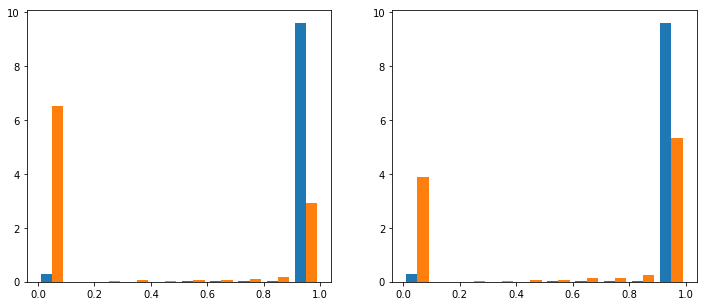

2 [1] 39826
10 ['CHK1', 'P18031']
(-1.1723346269424555, -inf)


/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log


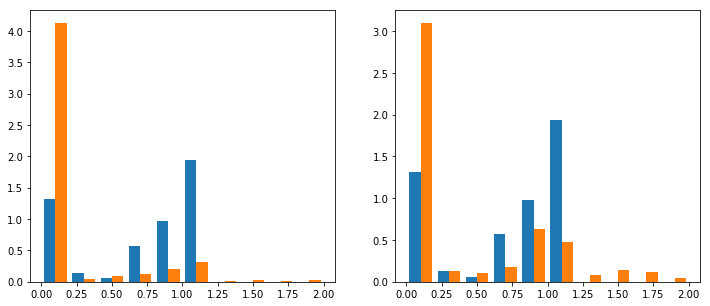

1 [2] 1553294
275 ['5HT2B', 'A2AR', 'P03951', 'SMO', 'ERA', 'M3', 'P07900', 'Q9Y233', 'P56817', 'O60885', 'PLK1', 'MEK1', 'JAK2', 'P00742', 'DTRANSP', 'P00749', 'P00760', 'B2AR', 'GCR', 'STRANSP', 'P00734', 'MGLUR5', 'Q16539', 'CHK1', 'CDK2', 'BRAF', 'MR', 'B1AR']
(-3.1997196558156427, -0.53356966387221938)


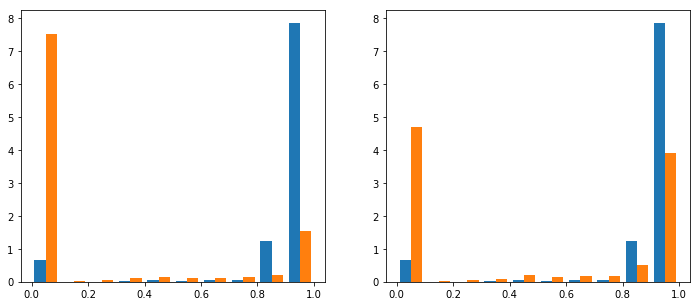

2 [2] 500471
141 ['Q16539', 'P03951', 'MGLUR5', 'P07900', 'GLUT1', 'Q9Y233', 'P56817', 'O60885', 'PLK1', 'MEK1', 'JAK2', 'P00742', 'TRPV1', 'AR', 'P24941', 'VITD', 'A2AR', 'P18031', 'CHK1', 'CDK2', 'GCR', 'BRAF', 'MR', 'B1AR']
(-3.2363845852742097, -0.39068060504731328)


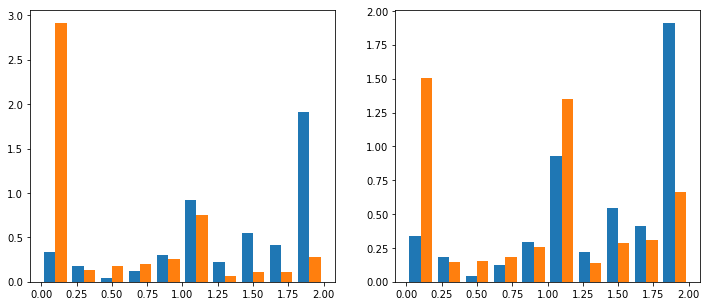

3 [2] 84566
29 ['P00489', 'P18031', 'P56817', 'CHK1', 'GCR', 'MR', 'P07900', 'AR', 'VITD']
(-inf, -0.43232388814343281)


/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log


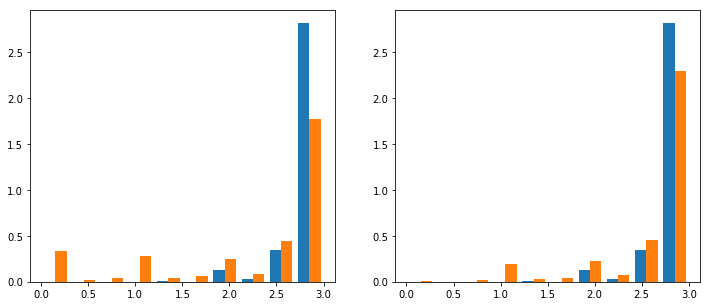

1 [3] 1219334
237 ['P00489', 'P03951', 'Q16539', 'SMO', 'ERA', 'M3', 'P07900', 'Q9Y233', 'P56817', 'O60885', 'PLK1', 'MEK1', 'JAK2', 'P00742', 'DTRANSP', 'GCR', 'P24941', 'VITD', 'A2AR', 'P18031', 'CHK1', 'CDK2', 'AR', 'BRAF', 'MR', 'STRANSP']
(-2.258134390403697, -1.1765210263887109)


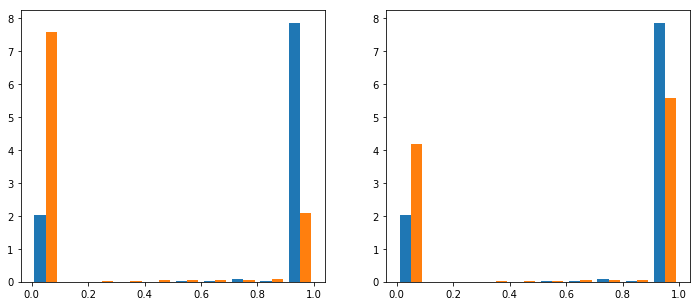

2 [3] 643864
190 ['P00489', 'P03951', 'ERA', 'P07900', 'P18031', 'P56817', 'O60885', 'PLK1', 'MEK1', 'JAK2', 'P00742', 'DTRANSP', 'TRPV1', 'P00760', 'A2AR', 'GCR', 'P24941', 'VITD', 'P00734', 'Q9Y233', 'Q16539', 'CHK1', 'CDK2', 'BRAF', 'MR', 'STRANSP']
(-2.2462772646822025, -0.47605128836841715)


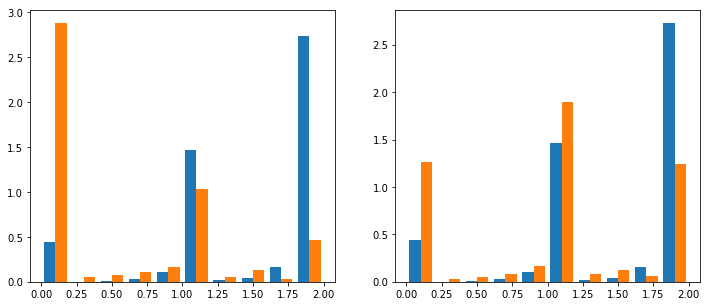

3 [3] 269041
80 ['P00734', 'B2AR', 'P00489', 'A2AR', 'PLK1', 'P56817', 'P03951', 'MEK1', 'JAK2', 'ERA', 'P00742', 'DTRANSP', 'B1AR', 'VITD', 'P24941', 'P00760']
(-3.1875047241682042, 0.53093165453937097)


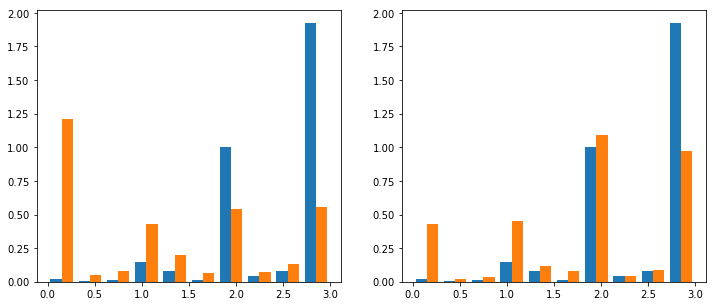

4 [3] 156500
41 ['P00734', 'B2AR', 'P56817', 'P00742', 'B1AR', 'P00749', 'P00760']
(-inf, -1.6466808465914378)


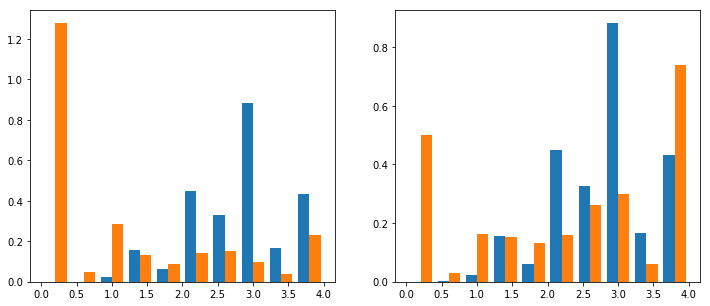

1 [6] 788778
137 ['P00734', 'A2AR', 'P00489', 'P03951', 'P18031', 'PLK1', 'P56817', 'Q16539', 'O60885', 'CDK2', 'P00742', 'Q9Y233', 'DTRANSP', 'VITD', 'P00749', 'P00760']
(-3.0453716067324157, -2.450442215948792)


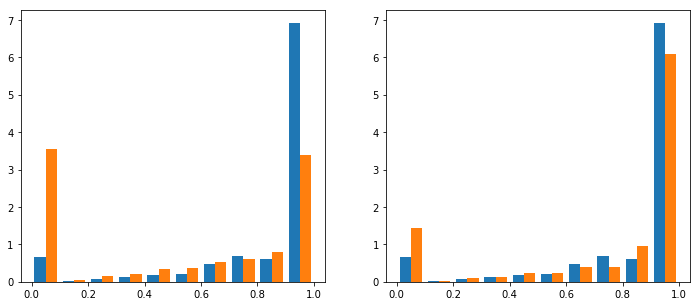

2 [6] 113771
26 ['P00734', 'P18031', 'CDK2', 'ERA', 'P00742', 'DTRANSP', 'BRAF']
(-5.8920092088505918, -inf)


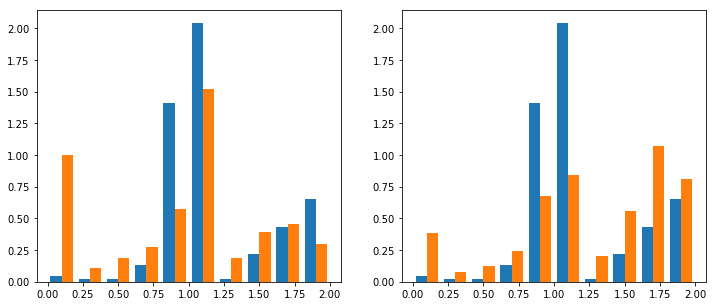

In [7]:
# native, decoy for different normalization factors
for codes in [[1], [2], [3], [6]]:
    for total in [1, 2, 3, 4]:
        all_proteins, all_ligands = set(), set()
        native, scores, p_glide = [], [], []
        for protein, ligands in data.items():
            for i, (ligand1, poses1) in enumerate(ligands.items()[:15]):
                for ligand2, poses2 in ligands.items()[i+1:15]:
                    norm = get_norm(poses1, poses2, codes)
                    if norm != total: continue
                    for rank1, pose1 in poses1.items():
                        if rank1 >= max_poses: continue
                        for rank2, pose2 in poses2.items():
                            if rank2 >= max_poses: continue
                            native += [pose1[2] <= 2 * pose2[2] <= 2]
                            scores += [overlap(pose1, pose2, codes)]
                            p_glide += [  interpolate(pose1[0], p_x, p_y)
                                        * interpolate(pose2[0], p_x, p_y)]
                            all_proteins.add(protein)
                            all_ligands.add(ligand1)
                            all_ligands.add(ligand2)
                        
        native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
        if not np.sum(native): continue
        print total, codes, len(native)
        print len(all_ligands), list(all_proteins)
        print (np.log(np.sum(scores[native == 1] == 0)) - np.log(np.sum(p_glide[scores==0])),
               np.log(np.sum(scores[native == 1] == total)) - np.log(np.sum(p_glide[scores==total])))
        f, ax = plt.subplots(1, 2, figsize = (12, 5))
        ax[0].hist([scores[native == 1], scores], normed = True)
        ax[1].hist([scores[native == 1], scores],
                 weights = [[1]*np.sum(native), p_glide], normed = True)
        plt.show()

1, 2, 3, 4 [1] 1308976
135 ['P00734', 'B2AR', 'Q9Y233', 'P24941', 'P18031', 'PLK1', 'P56817', 'P00749', 'CHK1', 'STRANSP', 'P03951', 'P00742', 'DTRANSP', 'P07900', 'SIGMA1', 'B1AR', 'P00760']
(-3.0170891620623541, 0.14133452740244579)


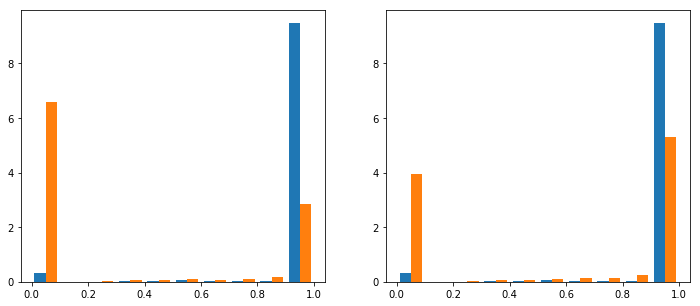

1, 2, 3, 4 [2] 2143331
329 ['P00489', '5HT2B', 'A2AR', 'PLK1', 'MGLUR5', 'ERA', 'M3', 'P07900', 'GLUT1', 'P18031', 'P56817', 'O60885', 'MEK1', 'JAK2', 'P00742', 'DTRANSP', 'P00749', 'P00760', 'B2AR', 'GCR', 'P24941', 'STRANSP', 'VITD', 'P00734', 'SMO', 'Q9Y233', 'P03951', 'TRPV1', 'Q16539', 'CHK1', 'CDK2', 'AR', 'BRAF', 'MR', 'B1AR']
(-3.2101770553623012, -0.50325904165092261)


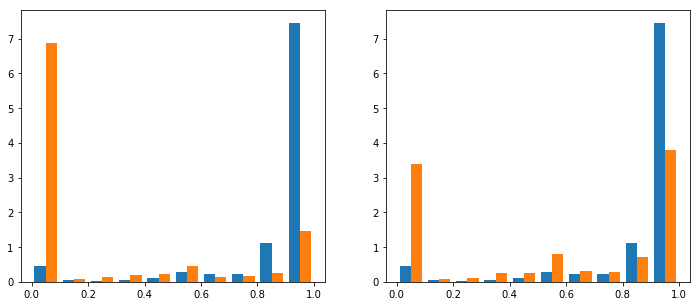

1, 2, 3, 4 [3] 2288739
353 ['P00489', 'A2AR', 'PLK1', 'SMO', 'ERA', 'M3', 'P07900', 'P18031', 'P56817', 'O60885', 'MEK1', 'JAK2', 'P00742', 'DTRANSP', 'P00749', 'P00760', 'B2AR', 'GCR', 'P24941', 'STRANSP', 'VITD', 'P00734', 'Q9Y233', 'P03951', 'TRPV1', 'Q16539', 'CHK1', 'CDK2', 'AR', 'BRAF', 'MR', 'B1AR']
(-2.3006511951384034, -0.74093949221619582)


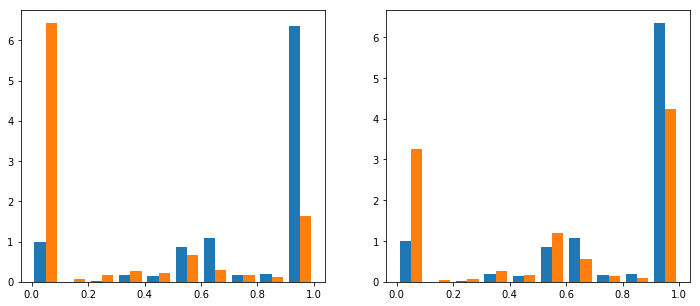

1, 2, 3, 4 [6] 902549
147 ['P00734', 'A2AR', 'P00489', 'P03951', 'P18031', 'PLK1', 'P56817', 'Q16539', 'BRAF', 'O60885', 'CDK2', 'ERA', 'P00742', 'Q9Y233', 'DTRANSP', 'VITD', 'P00749', 'P00760']
(-3.1449527179526466, -2.45291393940707)


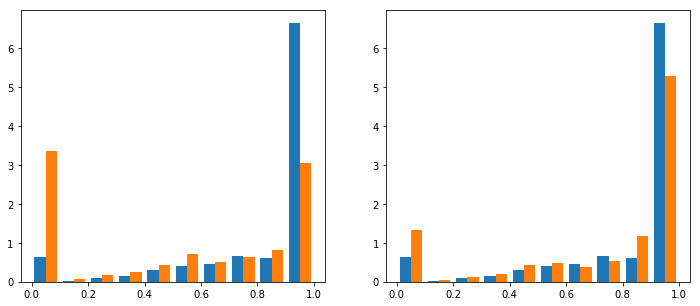

In [8]:
# native, decoy  merged
for codes in [[1], [2], [3], [6]]:
    all_proteins, all_ligands = set(), set()
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:15]):
            for ligand2, poses2 in ligands.items()[i+1:15]:
                norm = get_norm(poses1, poses2, codes)
                if norm not in [1, 2, 3, 4]: continue
                for rank1, pose1 in poses1.items():
                    if rank1 >= max_poses: continue
                    for rank2, pose2 in poses2.items():
                        if rank2 >= max_poses: continue
                        native += [pose1[2] <= 2 * pose2[2] <= 2]
                        scores += [overlap(pose1, pose2, codes) / float(norm)]
                        p_glide += [  interpolate(pose1[0], p_x, p_y)
                                    * interpolate(pose2[0], p_x, p_y)]
                        all_proteins.add(protein)
                        all_ligands.add(ligand1)
                        all_ligands.add(ligand2)

    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    if not np.sum(native): continue
    print '1, 2, 3, 4', codes, len(native)
    print len(all_ligands), list(all_proteins)
    print (np.log(np.sum(scores[native == 1] == 0)) - np.log(np.sum(p_glide[scores==0])),
           np.log(np.sum(scores[native == 1] == 1)) - np.log(np.sum(p_glide[scores==1])))
    f, ax = plt.subplots(1, 2, figsize = (12, 5))
    ax[0].hist([scores[native == 1], scores], normed = True)
    ax[1].hist([scores[native == 1], scores],
             weights = [[1]*np.sum(native), p_glide], normed = True)
    plt.show()

# P made in a native pose given made in at least one pose

[1] 878187


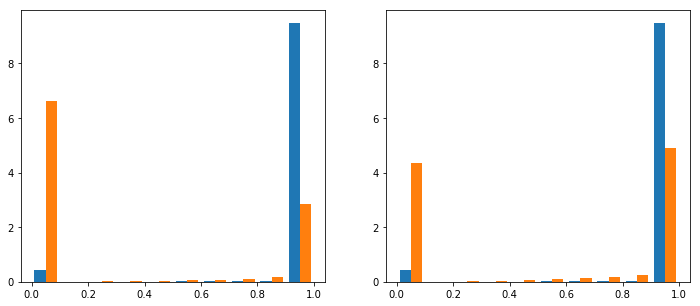

[2] 5171575


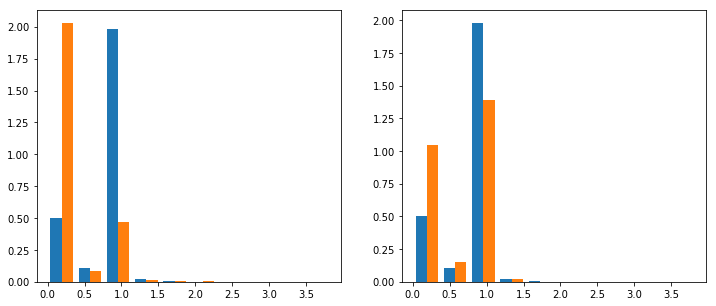

[3] 8481032


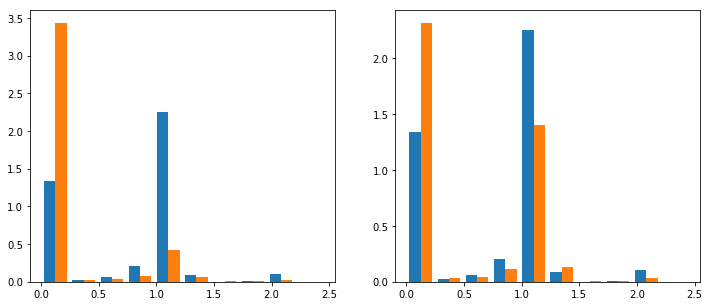

[6] 1311845


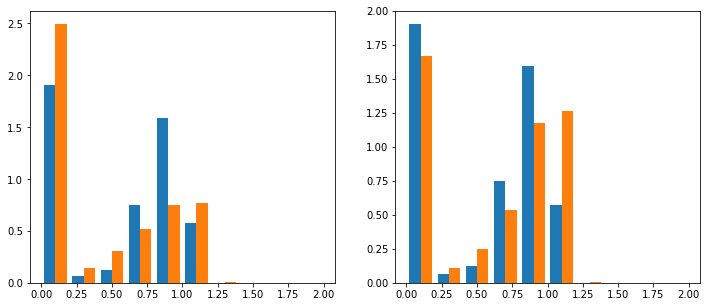

In [9]:
for codes in [[1], [2], [3], [6]]:
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:10]):
            for ligand2, poses2 in ligands.items()[i+1:10]:
                made = set()
                for rank1, pose1 in poses1.items():
                    if rank1 >= max_poses: continue
                    for rank2, pose2 in poses2.items():
                        if rank2 >= max_poses: continue
                        for (c, r), score1 in pose1[-1].items():
                            if c in codes and (c, r) in pose2[-1]:
                                if np.sqrt(score1*pose2[-1][(c, r)]) == 1.0:
                                    made.add((c, r))
                for rank1, pose1 in poses1.items():
                    if rank1 >= max_poses: continue
                    for rank2, pose2 in poses2.items():
                        if rank2 >= max_poses: continue
                        for k in made:
                            score1 = pose1[-1][k] if k in pose1[-1] else 0
                            score2 = pose2[-1][k] if k in pose2[-1] else 0
                            native += [pose1[2] <= 2 * pose2[2] <= 2]
                            scores += [np.sqrt(score1*score2)]
                            p_glide += [  interpolate(pose1[0], p_x, p_y)
                                        * interpolate(pose2[0], p_x, p_y)]

    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    print codes, len(native)
    f, ax = plt.subplots(1, 2, figsize = (12, 5))
    ax[0].hist([scores[native == 1], scores], normed = True)
    ax[1].hist([scores[native == 1], scores],
             weights = [[1]*np.sum(native), p_glide], normed = True)
    plt.show()

# Is there a difference between (0, 0) and (0, 1)?

[1] 1427460 35545


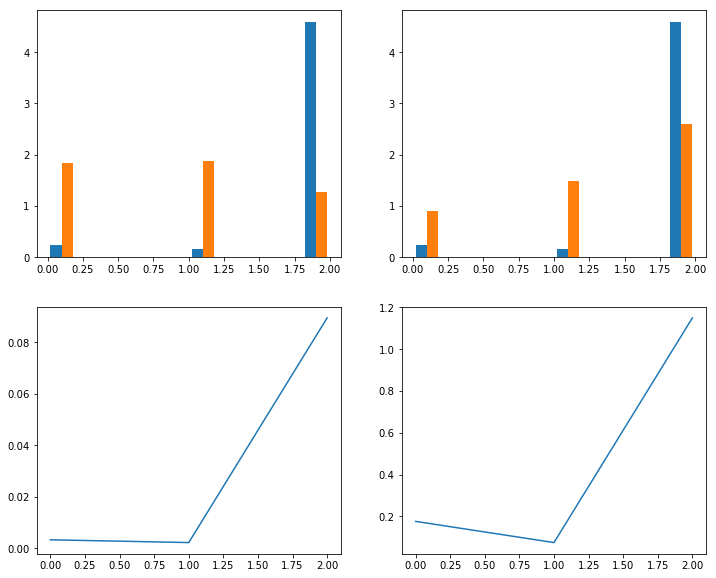

[2] 8618584 401178


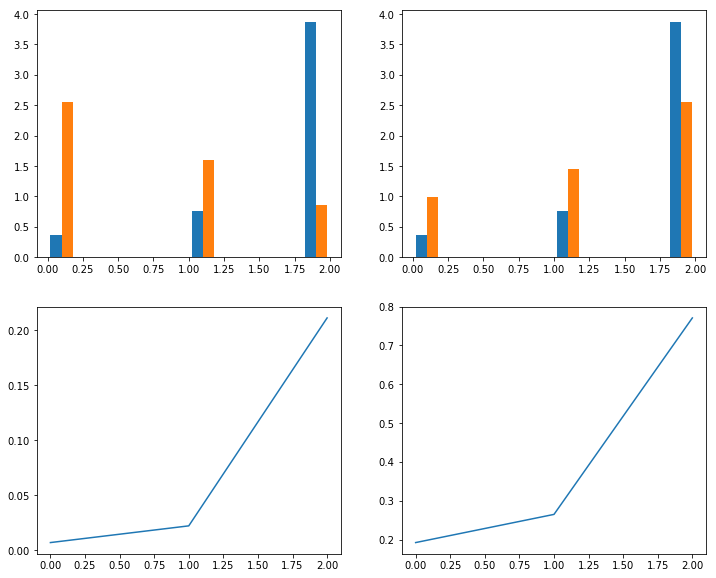

[3] 14946635 460493


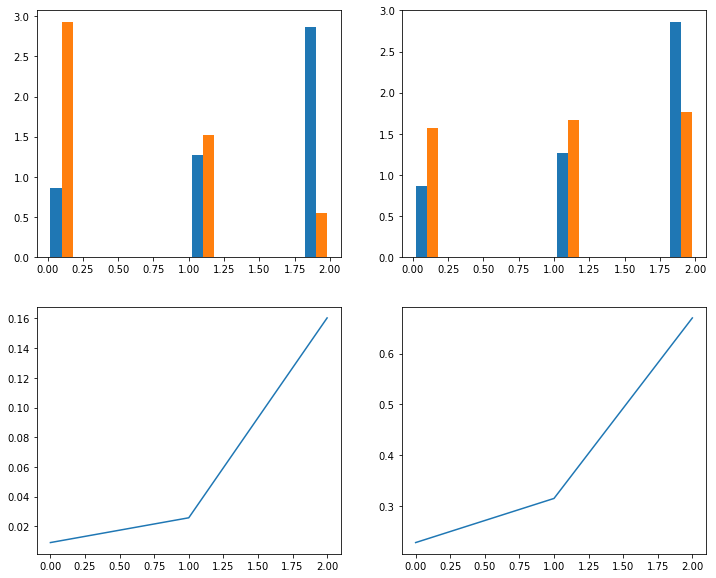

[6] 1195926 4969


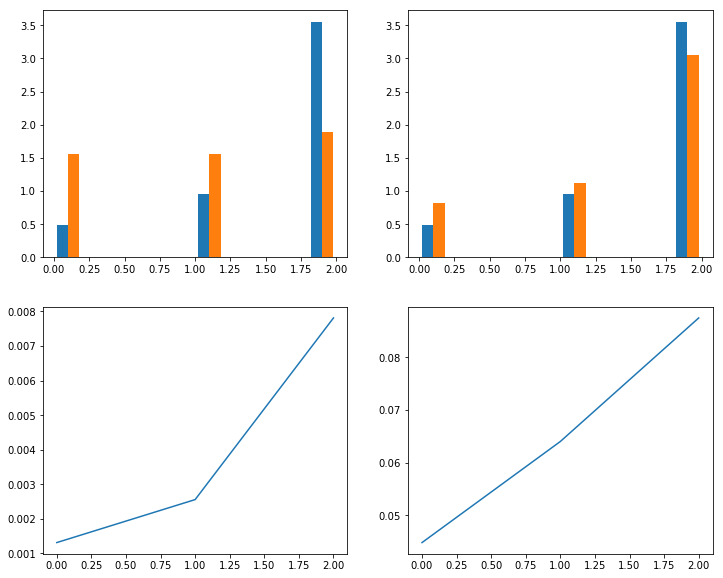

In [10]:
for codes in [[1], [2], [3], [6]]:
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        for i, (ligand1, poses1) in enumerate(ligands.items()[:15]):
            for ligand2, poses2 in ligands.items()[i+1:15]:
                made = set()
                for rank1, pose1 in poses1.items():
                    if rank1 > max_poses: continue
                    for rank2, pose2 in poses2.items():
                        if rank2 > max_poses: continue
                        for (c, r), score1 in pose1[-1].items():
                            if c in codes and (c, r) in pose2[-1]:
                                if np.sqrt(score1*pose2[-1][(c, r)]) == 1.0:
                                    made.add((c, r))
                for rank1, pose1 in poses1.items():
                    if rank1 > max_poses: continue
                    for rank2, pose2 in poses2.items():
                        if rank2 > max_poses: continue
                        for k in made:
                            score1 = pose1[-1][k] if k in pose1[-1] else 0
                            score2 = pose2[-1][k] if k in pose2[-1] else 0
                            if score1 not in [0, 1] or score2 not in [0, 1]: continue 
                            native += [pose1[2] <= 2 * pose2[2] <= 2]
                            scores += [(score1 == 1) + (score2 == 1)]
                            p_glide += [  interpolate(pose1[0], p_x, p_y)
                                        * interpolate(pose2[0], p_x, p_y)]

    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    print codes, len(native), np.sum(native)
    f, ax = plt.subplots(2, 2, figsize = (12, 10))
    ax[0, 0].hist([scores[native == 1], scores], normed = True)
    ax[0, 1].hist([scores[native == 1], scores],
                   weights = [[1]*np.sum(native), p_glide], normed = True)
    ax[1, 0].plot([np.sum(scores[native == 1] == i) / np.sum(scores == i).astype(float)
                   for i in range(3)])
    ax[1, 1].plot([np.sum(scores[native == 1] == i) / np.sum(p_glide[scores == i])
                   for i in range(3)])
    plt.show()

# Given that a ligand makes an interaction in at least one pose, what is the likelihood that the interaction is native?

[1] 11354 2068


/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide
/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide


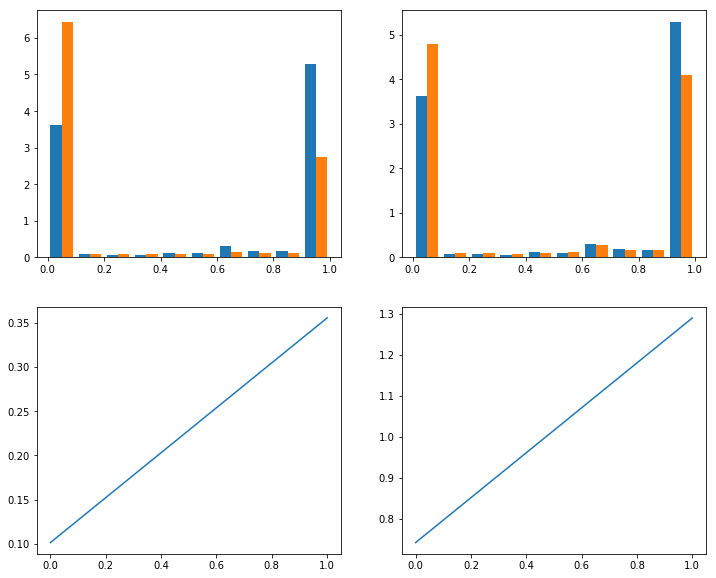

[2] 61125 13723


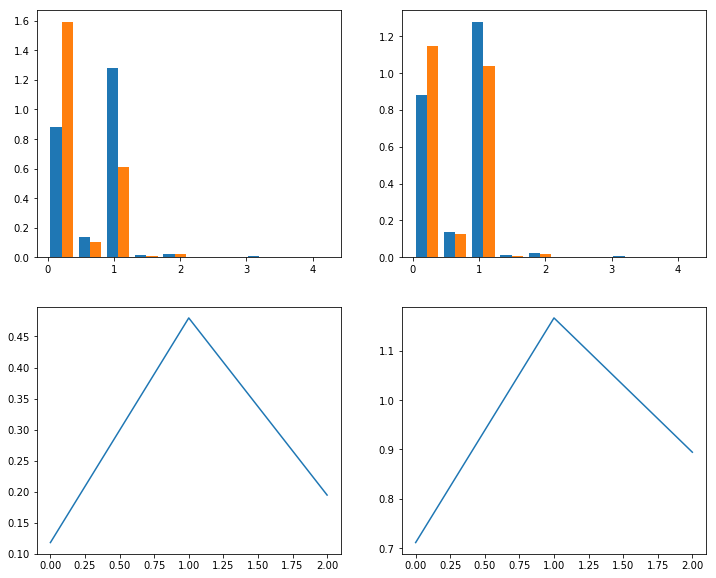

[3] 95881 18326


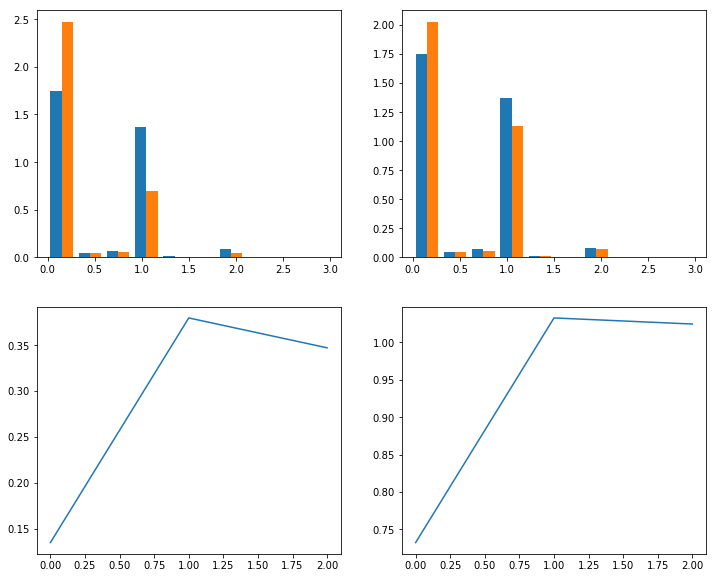

[6] 14817 2160


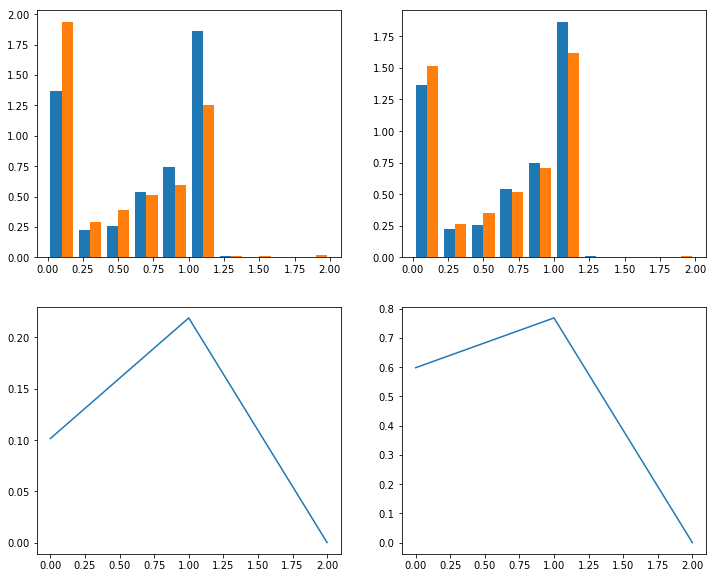

[11] 458 96


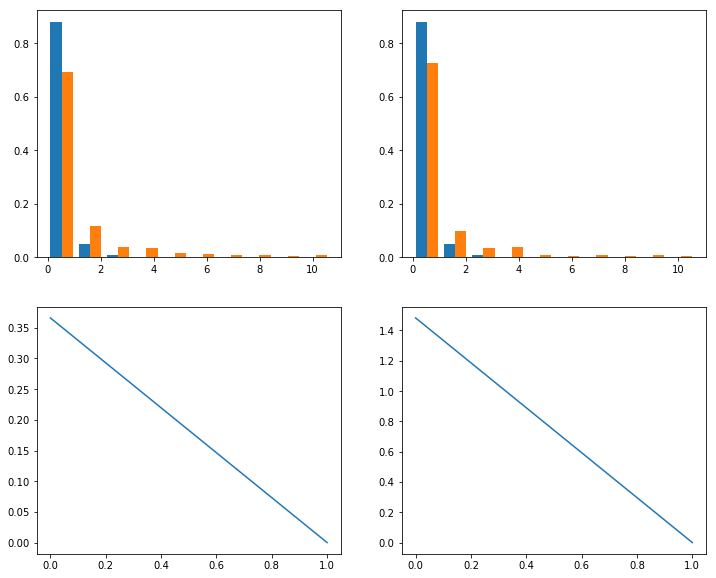

In [11]:
for codes in [[1], [2], [3], [6], [11]]:
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        if protein in ['B1AR', 'B2AR']: continue
        for i, (ligand, poses) in enumerate(ligands.items()[:15]):
            made = set()
            for rank, pose in poses.items():
                if rank > max_poses: continue
                for (c, r), score in pose[-1].items():
                    if c in codes and score == 1.0:
                        made.add((c, r))
            for rank, pose in poses.items():
                if rank > max_poses: continue
                for k in made:
                    native += [pose[2] <= 2]
                    scores += [pose[-1][k] if k in pose[-1] else 0]
                    p_glide += [interpolate(pose[0], p_x, p_y)]

    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    print codes, len(native), np.sum(native)
    f, ax = plt.subplots(2, 2, figsize = (12, 10))
    ax[0, 0].hist([scores[native == 1], scores], normed = True)
    ax[0, 1].hist([scores[native == 1], scores],
                   weights = [[1]*np.sum(native), p_glide], normed = True)
    ax[1, 0].plot([np.sum(scores[native == 1] == i) / np.sum(scores == i).astype(float)
                   for i in range(3)])
    ax[1, 1].plot([np.sum(scores[native == 1] == i) / np.sum(p_glide[scores == i])
                   for i in range(3)])
    plt.show()

[1] 5390 2114


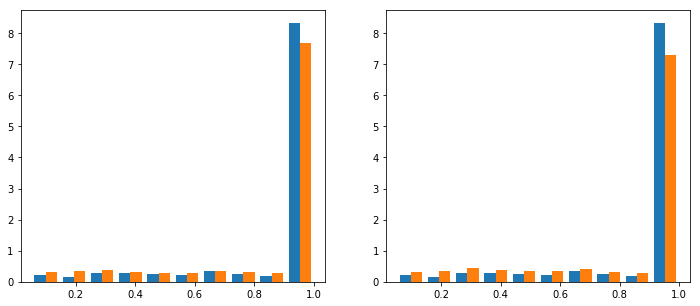

[2] 26185 11165


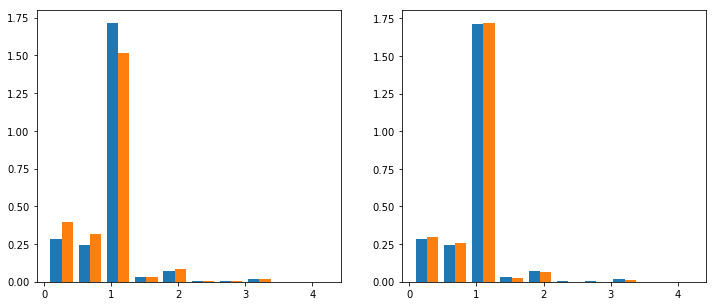

[3] 30423 10892


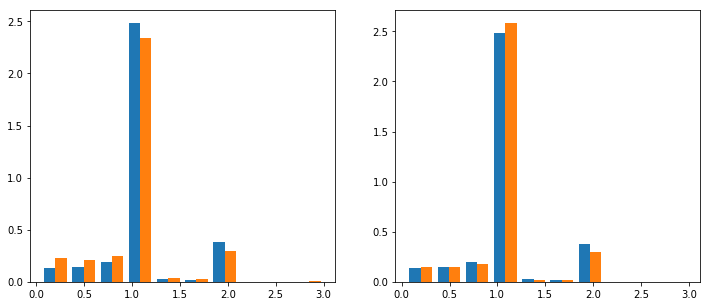

[6] 20715 5408


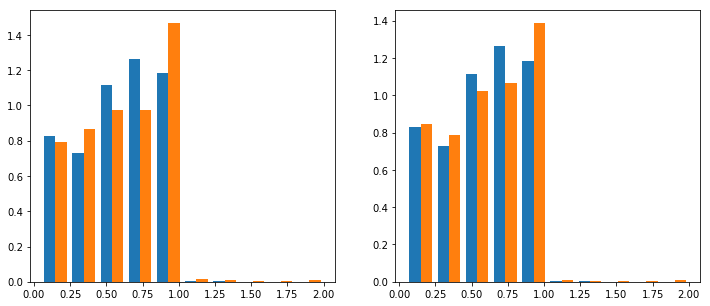

[11] 398039 127550


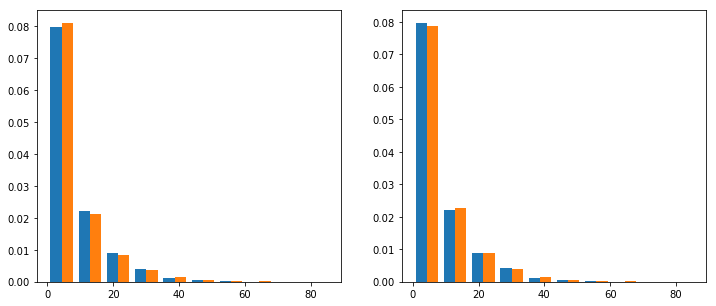

In [12]:
for codes in [[1], [2], [3], [6], [11]]:
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        for i, (ligand, poses) in enumerate(ligands.items()[:15]):
            for rank, pose in poses.items():
                if rank > max_poses: continue
                for (c, r), score in pose[-1].items():
                    if c in codes:
                        native  += [pose[2] <= 2]
                        scores  += [pose[-1][(c,r)]]
                        p_glide += [interpolate(pose[0], p_x, p_y)]
    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    print codes, len(native), np.sum(native)
    f, ax = plt.subplots(1, 2, figsize = (12, 5))
    ax[0].hist([scores[native == 1], scores], normed = True)
    ax[1].hist([scores[native == 1], scores],
                   weights = [[1]*np.sum(native), p_glide], normed = True)
    plt.show()

# Is there a dependency on number of interactions and glide performance? I.e. if in its native pose a ligand makes 1 hbond is it more or less likely to be correctly predicted than a ligand that makes 2 hbonds?

[1] 16730 7060


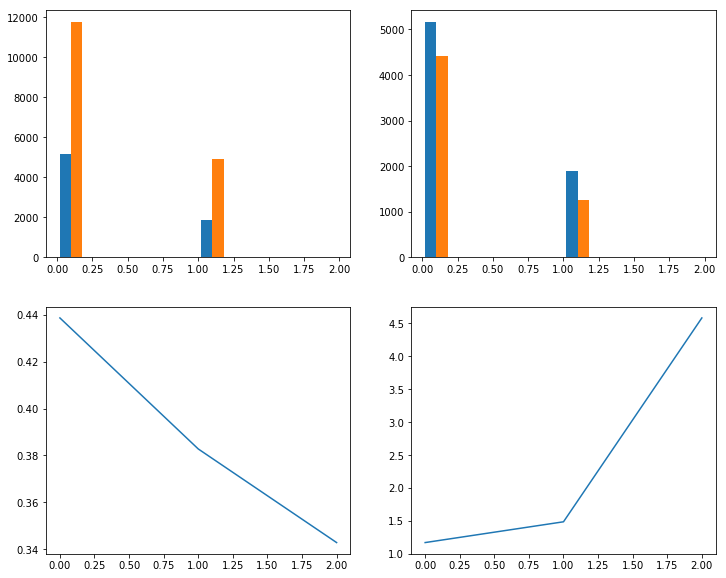

[2] 16730 7060


/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide
/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide


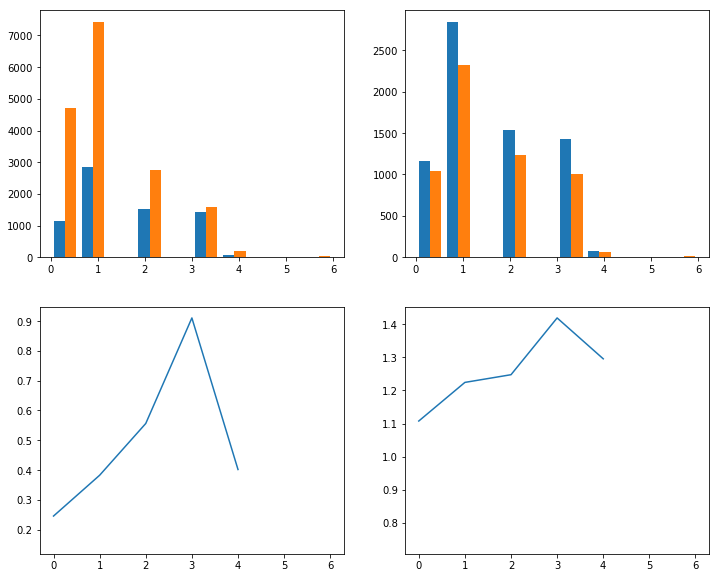

[3] 16730 7060


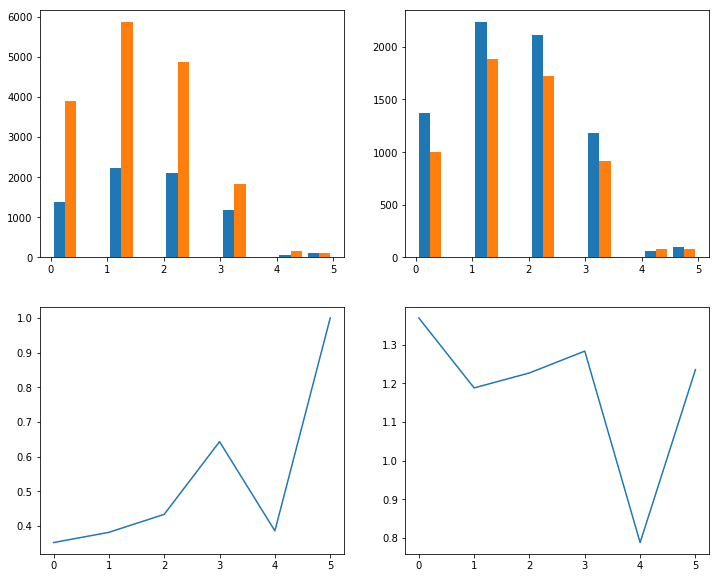

[6] 16730 7060


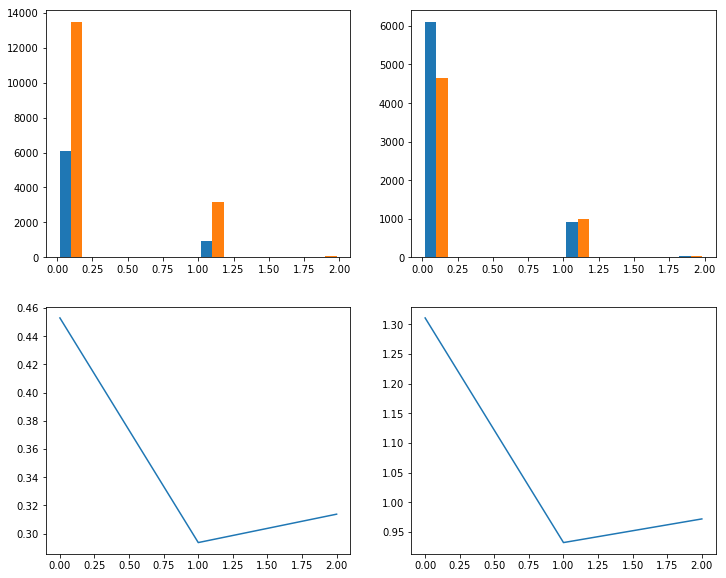

In [13]:
for codes in [[1], [2], [3], [6]]:
    native, scores, p_glide = [], [], []
    for protein, ligands in data.items():
        for i, (ligand, poses) in enumerate(ligands.items()):
            count = None
            for rank, pose in poses.items():
                if rank > max_poses: continue
                if pose[2] <= 2:
                    count = 0
                    for (c, r), score in pose[-1].items():
                        if c in codes and score == 1.0:
                            count += 1
                    break
            if count is None: continue
            for rank, pose in poses.items():
                if rank > max_poses: continue
                native += [pose[2] <= 2]
                scores += [count]
                p_glide += [interpolate(pose[0], p_x, p_y)]

    native, scores, p_glide = np.array(native), np.array(scores), np.array(p_glide)
    print codes, len(native), np.sum(native)
    f, ax = plt.subplots(2, 2, figsize = (12, 10))
    ax[0, 0].hist([scores[native == 1], scores])
    ax[0, 1].hist([scores[native == 1], scores],
                   weights = [[1]*np.sum(native), p_glide])
    ax[1, 0].plot([np.sum(scores[native == 1] == i) / np.sum(scores == i).astype(float)
                   for i in range(scores.max()+1)])
    ax[1, 1].plot([np.sum(scores[native == 1] == i) / np.sum(p_glide[scores == i])
                   for i in range(scores.max()+1)])
    plt.show()

In [32]:
X = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
x = .33
idx = 0
while x > X[idx]: idx += 1
print idx

if not idx:
    print y[0] # Avoid IndexError
else:
    d = X[idx] - X[idx-1]
    print (  y[idx-1]  * (X[idx] - x)/d
           + y[idx]    * (x - X[idx-1])/d)

3
0.33
